In [1]:
!pip install scikit-learn -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [2]:
# Importing core libraries
import numpy as np
import pandas as pd
from time import time
import pprint
import joblib

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Classifiers
import lightgbm as lgb

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Plotting functions
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set(style='whitegrid')

## 1. First steps

As first steps: 
* we load the train and test data from disk
* we separate the target from the training data
* we separate the ids from the test data (thus train and test data have the same structure)
* we convert integer variables to categories (thus our machine learning algorithm can pick them as categorical variables and not standard numeric one)

In [3]:
# Loading data 
X = pd.read_csv("../input/amazon-employee-access-challenge/train.csv")
X_test = pd.read_csv("../input/amazon-employee-access-challenge/test.csv")

# Separating the target from the predictors
y = X["ACTION"]
X.drop(["ACTION"], axis="columns", inplace=True)

# Separating the identifier from the test data
ids = X_test["id"]
X_test.drop("id", axis="columns", inplace=True)

# Converting all integer variables to categorical
integer_cols = X.select_dtypes(include=['int']).columns
X[integer_cols] = X[integer_cols].astype('category', copy=False)
X_test[integer_cols] = X_test[integer_cols].astype('category', copy=False)

# 2. EDA

At this point we have a look at the training and test data in order to figure out how we can process the data.

In [4]:
print("Unique values")
(pd.concat([X.apply(lambda x: len(x.unique())), 
            X_test.apply(lambda x: len(x.unique()))
           ], axis="columns")
 .rename(columns={0: "train", 1:"test"}))

Unique values


,train,test
RESOURCE,7518,4971
MGR_ID,4243,4689
ROLE_ROLLUP_1,128,126
ROLE_ROLLUP_2,177,177
ROLE_DEPTNAME,449,466
ROLE_TITLE,343,351
ROLE_FAMILY_DESC,2358,2749
ROLE_FAMILY,67,68
ROLE_CODE,343,351


In [5]:
print("Values in test but not in train")
for col in integer_cols:
    mismatched_codes = len(np.setdiff1d(X[col].unique(), X_test[col].unique()))
    print(f"{col:20} {mismatched_codes:4}")

Values in test but not in train
RESOURCE             2547
MGR_ID                224
ROLE_ROLLUP_1           4
ROLE_ROLLUP_2           6
ROLE_DEPTNAME          10
ROLE_TITLE             10
ROLE_FAMILY_DESC      202
ROLE_FAMILY             0
ROLE_CODE              10


In [6]:
print("Missing cases")
(pd.concat([X.isna().sum(), 
           X_test.isna().sum()
           ], axis="columns")
 .rename(columns={0: "train", 1:"test"}))

Missing cases


,train,test
RESOURCE,0,0
MGR_ID,0,0
ROLE_ROLLUP_1,0,0
ROLE_ROLLUP_2,0,0
ROLE_DEPTNAME,0,0
ROLE_TITLE,0,0
ROLE_FAMILY_DESC,0,0
ROLE_FAMILY,0,0
ROLE_CODE,0,0


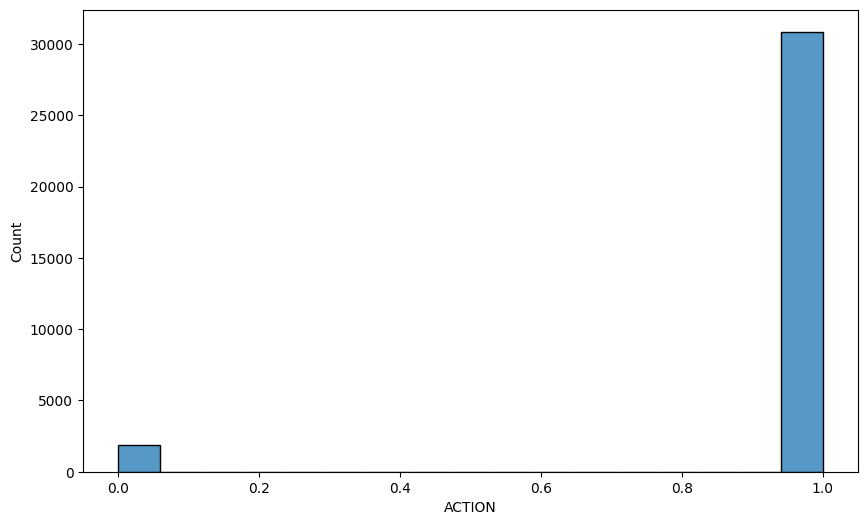

In [7]:
# label distribution
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(y, ax=ax)
plt.show()

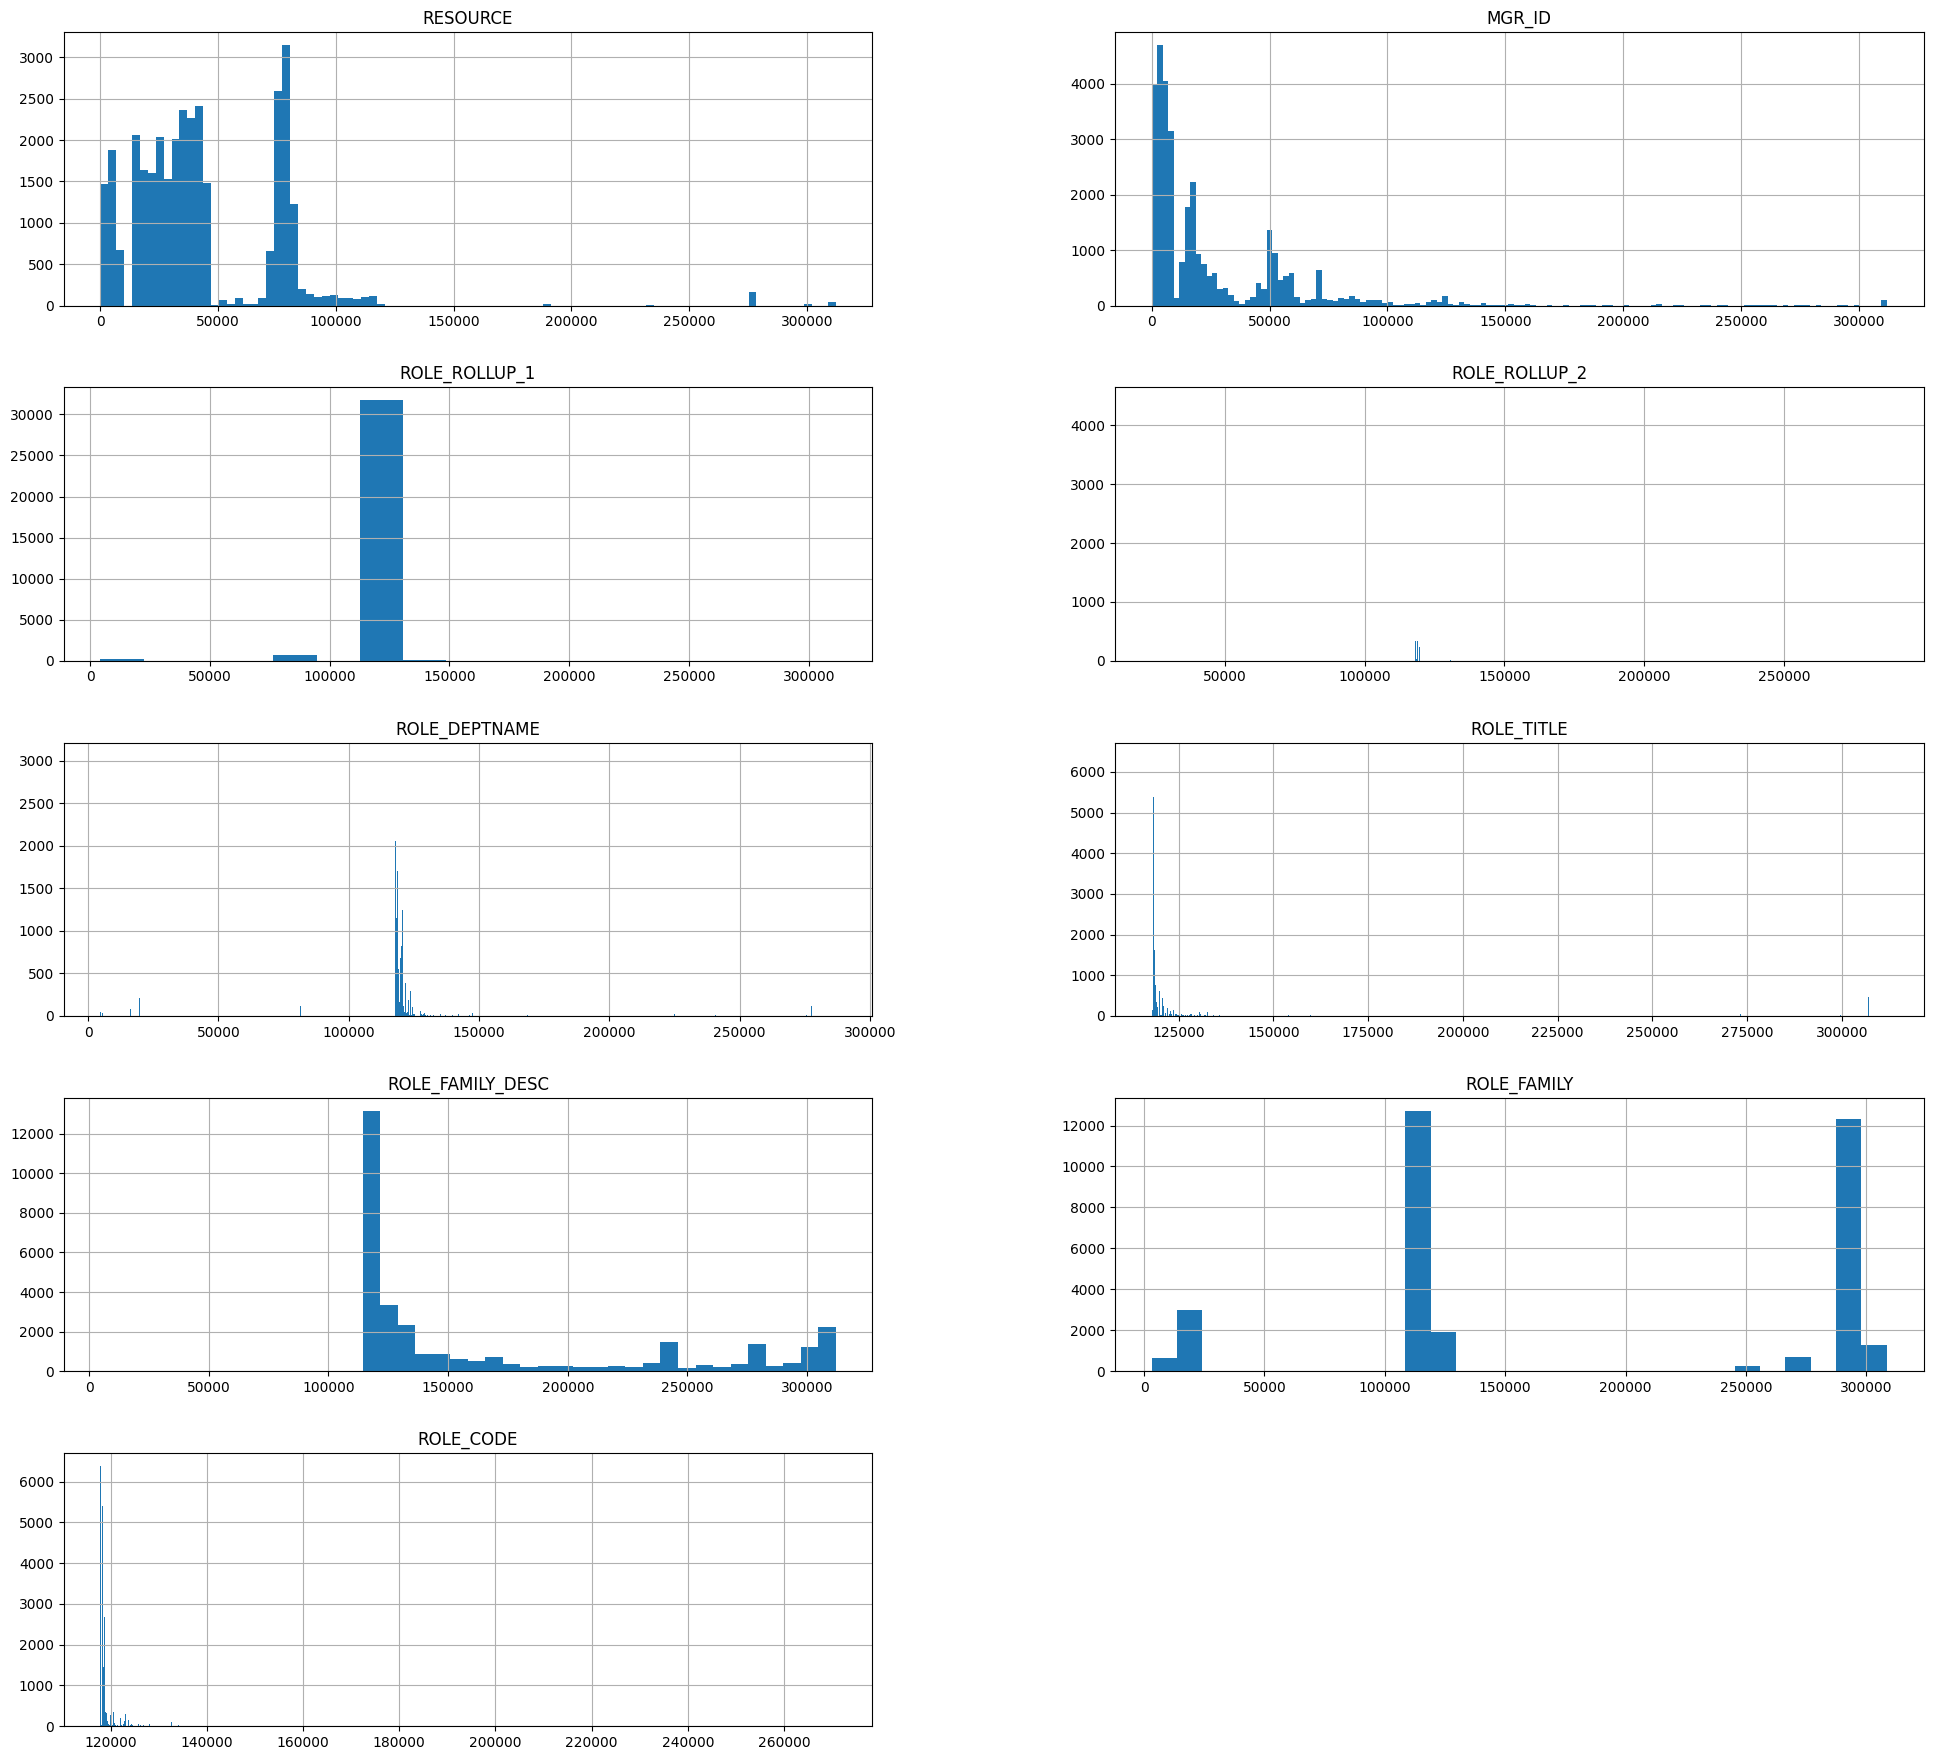

In [8]:
# Distribution of values of variables
_ = X.astype(int).hist(bins='auto', figsize=(24, 22), layout=(5, 2))

From the EDA we can get a few hints about what to do:
* the target classes are unbalanced, we should consider re-balancing the data
* all the categorical features have a different number of values ranging from 70 to up to over 7000 (high cardinality features)
* there are no missing values but many categorical values appear just in test, not in train (this especially affects the RESOURCE feature)
* the categorical values are sparse

# 3. Feature engineering

As the categorical features are sparsed and mismatched, we replace the original values with contiguous values, substituing with the value -1 in the test set for values that are not present in the train set. This operation should permit the LightGBM 

In [9]:
for col in integer_cols:
    unique_values = sorted(X[col].unique())
    print(col, ":", unique_values[:5],'...', unique_values[-5:])
    conversion_dict = dict(zip(unique_values, range(len(unique_values))))
    # When working with the Categorical’s codes, missing values will always have a code of -1.
    X[col] = X[col].map(conversion_dict, na_action=-1).astype('category', copy=False)
    X_test[col] = X_test[col].map(conversion_dict, na_action=-1).astype('category', copy=False)

RESOURCE : [0, 38, 136, 138, 153] ... [312136, 312139, 312140, 312152, 312153]
MGR_ID : [25, 27, 30, 32, 33] ... [311597, 311651, 311682, 311683, 311696]
ROLE_ROLLUP_1 : [4292, 5110, 11146, 91261, 117876] ... [203209, 209434, 216705, 247952, 311178]
ROLE_ROLLUP_2 : [23779, 31010, 32137, 117877, 117883] ... [151110, 159716, 176316, 185842, 286791]
ROLE_DEPTNAME : [4674, 5488, 5606, 6104, 6725] ... [272283, 274241, 275600, 277693, 286792]
ROLE_TITLE : [117879, 117885, 117896, 117899, 117905] ... [297560, 299559, 307024, 310825, 311867]
ROLE_FAMILY_DESC : [4673, 62587, 117879, 117886, 117897] ... [311782, 311792, 311834, 311839, 311867]
ROLE_FAMILY : [3130, 4673, 6725, 19721, 19793] ... [254395, 270488, 290919, 292795, 308574]
ROLE_CODE : [117880, 117888, 117898, 117900, 117908] ... [254396, 258436, 266863, 268610, 270691]


In [10]:
print("Missing cases")
pd.concat([X.isna().sum(), X_test.isna().sum()], axis="columns").rename(columns={0: "train", 1:"test"})

Missing cases


,train,test
RESOURCE,0,0
MGR_ID,0,1627
ROLE_ROLLUP_1,0,4
ROLE_ROLLUP_2,0,12
ROLE_DEPTNAME,0,62
ROLE_TITLE,0,30
ROLE_FAMILY_DESC,0,1249
ROLE_FAMILY,0,1
ROLE_CODE,0,30


# 4. Setting up optimization

First, we create a wrapper function to deal with running the optimizer and reporting back its best results.

In [11]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

We then define the evaluation metric, using the Scikit-learn function make_scorer allows us to convert the optimization into a minimization problem, as required by Scikit-optimize.

In [12]:
# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

We set up a stratified 5-fold cross validation: stratification helps us to obtain representative folds of the data and the target, though the target is unbalanced.

In [13]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

We set up a generic LightGBM classifier.

In [14]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0)

We define a search space, expliciting the key hyper-parameters to optimize and the range where to look for the best values.

In [15]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'max_bin': Integer(100, 1000),                       # Max number of bins that feature values will be bucketed
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight (hessian) needed in a child (leaf)
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
    'scale_pos_weight': Real(1.0, 500.0, 'uniform'),     # Weighting of the minority class (Only for binary classification)
        }

We then define the Bayesian optimization engine, providing to it our LightGBM, the search spaces, the evaluation metric, the cross-validation. We set a large number of possible experiments and some parallelism in the search operations.

In [16]:
opt = BayesSearchCV(estimator=clf,                                    
                    search_spaces=search_spaces,                      
                    scoring=roc_auc,                                  
                    cv=skf,                                           
                    n_iter=3000,                                      # max number of trials
                    n_points=3,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=-1,                                        # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

Finally we runt the optimizer and wait for the results. We have set some limits to its operations: we required it to stop if it cannot get consistent improvements from the search (DeltaYStopper) and time dealine set in seconds (we decided for 45 minutes).

In [17]:
overdone_control = DeltaYStopper(delta=0.0001)               # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60 * 45)     # We impose a time limit (45 minutes)

best_params = report_perf(opt, X, y,'LightGBM', 
                          callbacks=[overdone_control, time_limit_control])

LightGBM took 2784.67 seconds,  candidates checked: 39, best CV score: 0.859 ± 0.008
Best parameters:
OrderedDict([('colsample_bytree', 0.347317198182373),
             ('learning_rate', 0.6603977180639046),
             ('max_bin', 913),
             ('max_depth', 146),
             ('min_child_samples', 124),
             ('min_child_weight', 3.1525373138523585),
             ('n_estimators', 4554),
             ('num_leaves', 308),
             ('reg_alpha', 1.774462402814678e-07),
             ('reg_lambda', 3.6548521376945084e-07),
             ('scale_pos_weight', 5.448725516779605),
             ('subsample', 0.45527937996999446),
             ('subsample_freq', 0)])



# 5. Prediction on test data

Having got the best hyperparameters for the data at hand, we instantiate a lightGBM using such values and train our model on all the available examples.
<P>After having trained the model, we predict on the test set and we save the results on a csv file.

In [18]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',
                         metric='auc',
                         objective='binary',
                         n_jobs=1, 
                         verbose=-1,
                         random_state=0,
                         **best_params)

In [19]:
clf.fit(X, y)

LGBMClassifier(colsample_bytree=0.347317198182373,
               learning_rate=0.6603977180639046, max_bin=913, max_depth=146,
               metric='auc', min_child_samples=124,
               min_child_weight=3.1525373138523585, n_estimators=4554, n_jobs=1,
               num_leaves=308, objective='binary', random_state=0,
               reg_alpha=1.774462402814678e-07,
               reg_lambda=3.6548521376945084e-07,
               scale_pos_weight=5.448725516779605,
               subsample=0.45527937996999446, verbose=-1)

In [20]:
submission = pd.DataFrame({'Id':ids, 'ACTION': clf.predict_proba(X_test)[:, 1].ravel()})
submission.to_csv("submission.csv", index = False)